# Yelp Multi-Label Classification 

Dans cet exercice, nous allons monter en difficulter et essayer d'entrer dans la [compétition Kaggle de Yelp](https://www.kaggle.com/c/yelp-restaurant-photo-classification/overview). Yelp souhaiterait en effet voir "l'ambiance d'un restaurant" à partir d'une image. On aura les labels suivants à prédire sur l'image : 

* Bien pour les dejeuners
* Bien pour les dîners 
* Prends des réservation 
* Terrasse disponible
* Restaurant est cher ou non
* Sert de l'alcool 
* Sert à Table 
* L'ambiance est classieux 
* Bien pour les enfants. 

Au lieu de faire de la classification d'un seul label (i.e chat/chien), cette fois, nous allons devoir placer plusieurs labels sur la même photos. Voyons donc comment nous pouvons résoudre ce challenge avec TensorFlow. 

* Commencez par installer : 
  * --upgrade tensorflow 
  * kaggle 

In [1]:
!pip install kaggle

In [0]:
#!pip install --upgrade tensorflow

* Pour la suite, nous allons utiliser l'API de Kaggle pour télécharger des données (trop volumineuses pour le faire autrement)
  * Allez sur l'API de Kaggle et regardez comment télécharger votre fichier `kaggle.json` : [Kaggle API](https://github.com/Kaggle/kaggle-api)
  * Pour la suite, il faut que vous placiez votre `kaggle.json` dans le dossier `/root` de votre Google Colab (ou votre machine en local) 
  * Essayez donc de faire cela en utilisant les commandes de votre terminal
  * Voici des rappels 

  <img src="https://i.redd.it/rl0fe7r6zku11.jpg" alt="linux cmd" height=700>

In [0]:
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

* Utilisez la commande `!kaggle compitions download -p /content -c yelp-restaurant-photo-classification` pour télécharger tous les éléments 

In [4]:
!kaggle competitions download -p /content -c yelp-restaurant-photo-classification -f train.csv.tgz

  0% 0.00/7.12k [00:00<?, ?B/s]
100% 7.12k/7.12k [00:00<00:00, 10.6MB/s]


In [5]:
!kaggle competitions download -p /content -c yelp-restaurant-photo-classification -f train_photos.tgz 

100% 6.54G/6.55G [02:20<00:00, 61.6MB/s]
100% 6.55G/6.55G [02:20<00:00, 50.1MB/s]


In [6]:
!kaggle competitions download -p /content -c yelp-restaurant-photo-classification -f train_photo_to_biz_ids.csv.tgz

  0% 0.00/1.12M [00:00<?, ?B/s]
100% 1.12M/1.12M [00:00<00:00, 75.3MB/s]


* En utilisant la commande `!unzip` dezippez les fichiers en `.zip`

In [7]:
!unzip /content/train_photos.tgz.zip -d /content/

Archive:  /content/train_photos.tgz.zip
  inflating: /content/train_photos.tgz  


In [8]:
!unzip /content/train_photo_to_biz_ids.csv.tgz.zip -d /content/

Archive:  /content/train_photo_to_biz_ids.csv.tgz.zip
  inflating: /content/train_photo_to_biz_ids.csv.tgz  


* Nous avons à gérer des fichiers en `.tgz`. Utilisez donc la librairie `tarfile` pour pouvoir les décompresser à nouveau. Voici un lien vers la documentation pour vous aider : [Tarfile Documentation](https://www.journaldev.com/17946/python-tarfile-module)

In [9]:
!tar zxvf /content/train_photos.tgz --exclude='._*.jpg' -C /content/

Streaming output truncated to the last 5000 lines.
train_photos/90810.jpg
train_photos/90811.jpg
train_photos/90813.jpg
train_photos/90815.jpg
train_photos/90817.jpg
train_photos/90818.jpg
train_photos/9082.jpg
train_photos/90821.jpg
train_photos/90824.jpg
train_photos/90825.jpg
train_photos/90828.jpg
train_photos/90830.jpg
train_photos/90831.jpg
train_photos/90833.jpg
train_photos/90836.jpg
train_photos/90837.jpg
train_photos/90839.jpg
train_photos/90844.jpg
train_photos/90848.jpg
train_photos/90849.jpg
train_photos/9085.jpg
train_photos/90850.jpg
train_photos/90851.jpg
train_photos/90858.jpg
train_photos/9086.jpg
train_photos/90860.jpg
train_photos/90862.jpg
train_photos/90864.jpg
train_photos/90865.jpg
train_photos/90869.jpg
train_photos/9087.jpg
train_photos/90870.jpg
train_photos/90871.jpg
train_photos/90872.jpg
train_photos/90875.jpg
train_photos/90877.jpg
train_photos/90878.jpg
train_photos/90879.jpg
train_photos/9088.jpg
train_photos/90880.jpg
train_photos/90882.jpg
train_photo

In [10]:
!tar zxvf train_photo_to_biz_ids.csv.tgz -C /content/

./._train_photo_to_biz_ids.csv
train_photo_to_biz_ids.csv


In [11]:
!tar zxvf train.csv.tgz -C /content/

train.csv


In [0]:
!rm /content/train_photo_to_biz_ids.csv.tgz \
&& rm /content/train_photo_to_biz_ids.csv.tgz.zip \
&& rm /content/train_photos.tgz \
&& rm /content/train_photos.tgz.zip \
&& rm /content/train.csv.tgz

* Importez les librairies suivantes : 

  * Pandas 
  * Matplotlib
  * Tensorflow 
  * pathlib
  * from sklearn.preprocessing import MultiLabelBinarizer

In [13]:
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import pathlib
from time import time
from sklearn.model_selection import train_test_split
import os

tf.__version__

'2.2.0-rc3'

* Créez une fonction `clean_path_img` qui va :
  * Créer un objet `Path` pour toutes les images ayant une extension `.jpg`
  * Transformer les objets `Path` en `str`
  * Filtrer tous les chemins d'images qui commencent par un `.` (ce sont des images corrompues dans le dataset

In [0]:
ids = pd.read_csv('/content/train_photo_to_biz_ids.csv')

* Regardez la taille finale de votre dataset 

In [15]:
ids.columns

Index(['photo_id', 'business_id'], dtype='object')

In [0]:
train = pd.read_csv('/content/train.csv')

In [17]:
train.columns

Index(['business_id', 'labels'], dtype='object')

In [18]:
df = pd.merge(ids, train, how='inner', on='business_id')

df = df.dropna()
df = df.sample(frac=0.1).reset_index(drop=True)

df.head()

,photo_id,business_id,labels
0,452969,1114,1 2 4 5 6 7
1,424966,2038,1 2 3 4 5 6 7 8
2,107895,3988,3 6 8
3,149179,3702,3 5 6 8
4,17210,1070,1 2 5 6 8


* Créez maintenant une fonction `mapping_dataset` qui va: 
  * Lire les deux fichiers `train.csv` & `train_photo_to_biz_ids.csv`
  * Fusionner les deux fichiers 
  * Créer une colonne contenant tous les chemins vers chacune des images correspondant à son label
  * Enlever les NaN 
  * Prendre un sample de 60% des données (pour limiter le temps d'entrainement par la suite) 

* Faites un train / test split 

In [19]:
X_train, X_val, y_train, y_val = train_test_split(df['photo_id'], df['labels'].str.split(' '), test_size=0.2, random_state=42)

print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  18763
Number of posters for validation:  4691


In [20]:
X_train = [os.path.join('/content/train_photos/', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('/content/train_photos/', str(f)+'.jpg') for f in X_val]
X_train[:3]

['/content/train_photos/459731.jpg',
 '/content/train_photos/42580.jpg',
 '/content/train_photos/52043.jpg']

In [21]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['0', '8'], ['1', '2', '3', '5', '6', '8'], ['1', '2', '4', '5', '6']]

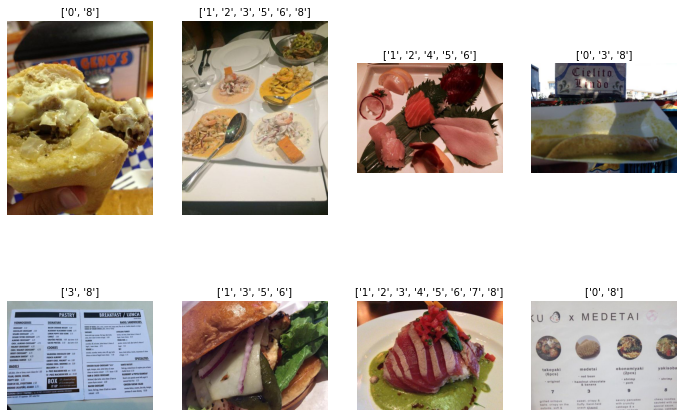

In [22]:
from PIL import Image

nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

* Nous allons devoir créer des versions `one_hot_encoder` de nos labels. Pour cela nous allons devoir utiliser le module `MultiLabelBinarizer()` de sklearn. Créer donc une fonction qui va : 
  * Créer une instance de `MultiLabelBinarizer`
  * Fitter l'instance sur les labels de notre dataset 
  * Transformer les labels en une liste de 0 & 1 

* Si vous faites une boucles sur les 10 premiers éléments, vous pourrez donc trouver les labels correspondant à chacun des chemins de vos images. 

In [23]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()

mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. 0
1. 1
2. 2
3. 3
4. 4
5. 5
6. 6
7. 7
8. 8


In [0]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [25]:
# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

/content/train_photos/459731.jpg [1 0 0 0 0 0 0 0 1]
/content/train_photos/42580.jpg [0 1 1 1 0 1 1 0 1]
/content/train_photos/52043.jpg [0 1 1 0 1 1 1 0 0]


# TensorFlow Dataset 

Nous allons passer à la création du dataset TensorFlow 

* Créez une fonction `parse_function` qui va 
  * Lire les chemins de chaque image 
  * Décoder les images 
  * Retailler les images en (224, 224, 3)
  * Divisez les tenseurs par 255

In [0]:
IMG_SIZE = 224 
CHANNELS = 3 

In [0]:
def parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0

    return image_normalized, label

In [0]:
BATCH_SIZE = 256 
AUTOTUNE = tf.data.experimental.AUTOTUNE 
SHUFFLE_BUFFER_SIZE = 1024

In [0]:
def create_dataset(filenames, labels, is_training=True):

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:

        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [0]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [31]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 9)


# Model Architecture -> loss = F1 Score

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 9)                 9225      
Total params: 3,578,953
Trainable params: 1,320,969
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.0840077  0.47774222 0.8167759  0.22197257 0.27714926 0.79764193
  0.7032488  0.21249244 0.2261629 ]]


In [0]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [0]:
LR = 1e-5
EPOCHS = 30

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

* Fittez votre modèle sur 5 à 10 epochs 

ATTENTION : Cet entrainement sera long ! (environs 5 min / epochs)

In [0]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))

print('\nTraining took {0:4.2f} min'.format(int(time()-start)/60))

Epoch 1/30
74/74 [==============================] - 41s 555ms/step - loss: 0.4298 - macro_f1: 0.5892 - val_loss: 0.3700 - val_macro_f1: 0.6737
Epoch 2/30
74/74 [==============================] - 16s 222ms/step - loss: 0.3521 - macro_f1: 0.6767 - val_loss: 0.3427 - val_macro_f1: 0.6749
Epoch 3/30
74/74 [==============================] - 16s 222ms/step - loss: 0.3356 - macro_f1: 0.6771 - val_loss: 0.3341 - val_macro_f1: 0.6751
Epoch 4/30
74/74 [==============================] - 16s 221ms/step - loss: 0.3298 - macro_f1: 0.6777 - val_loss: 0.3298 - val_macro_f1: 0.6770
Epoch 5/30
74/74 [==============================] - 16s 221ms/step - loss: 0.3257 - macro_f1: 0.6810 - val_loss: 0.3269 - val_macro_f1: 0.6811
Epoch 6/30
74/74 [==============================] - 16s 222ms/step - loss: 0.3228 - macro_f1: 0.6847 - val_loss: 0.3241 - val_macro_f1: 0.6838
Epoch 7/30
74/74 [==============================] - 16s 222ms/step - loss: 0.3203 - macro_f1: 0.6870 - val_loss: 0.3216 - val_macro_f1: 0.6850

* Visualisez votre accuracy par rapport à vos epochs sur votre train & test

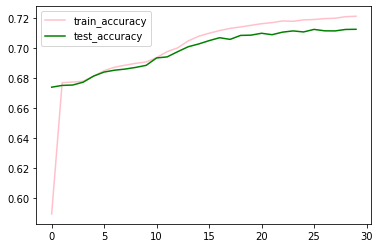

In [0]:
# Visualise train / Valid Accuracy
plt.plot(history.history["macro_f1"], c="pink", label="train_accuracy")
plt.plot(history.history["val_macro_f1"], c="green", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

* Faites de même avec votre loss

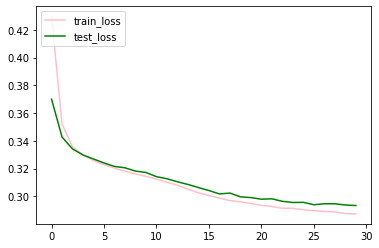

In [0]:
# Visualise train / Valid Loss
plt.plot(history.history["loss"], c="pink", label="train_loss")
plt.plot(history.history["val_loss"], c="green", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [0]:
print("Macro soft-F1 loss: %.2f" %history.history["val_loss"][-1])
print("Macro F1-score: %.2f" %history.history["val_macro_f1"][-1])

Macro soft-F1 loss: 0.29
Macro F1-score: 0.71


# MobilenetV2 - loss -> BinaryCrossEntropy

* Entrainez à nouveau votre modèle sur 5 à 10 epochs 

In [0]:
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=LR),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))

print('\nTraining took {0:4.2f} min'.format(int(time()-start)/60))

Epoch 1/30
74/74 [==============================] - 19s 257ms/step - loss: 0.7299 - macro_f1: 0.5450 - val_loss: 0.7134 - val_macro_f1: 0.5429
Epoch 2/30
74/74 [==============================] - 16s 221ms/step - loss: 0.7046 - macro_f1: 0.5478 - val_loss: 0.6979 - val_macro_f1: 0.5458
Epoch 3/30
74/74 [==============================] - 16s 222ms/step - loss: 0.6916 - macro_f1: 0.5467 - val_loss: 0.6875 - val_macro_f1: 0.5402
Epoch 4/30
74/74 [==============================] - 16s 222ms/step - loss: 0.6838 - macro_f1: 0.5444 - val_loss: 0.6820 - val_macro_f1: 0.5396
Epoch 5/30
74/74 [==============================] - 17s 223ms/step - loss: 0.6770 - macro_f1: 0.5450 - val_loss: 0.6757 - val_macro_f1: 0.5387
Epoch 6/30
74/74 [==============================] - 16s 222ms/step - loss: 0.6720 - macro_f1: 0.5467 - val_loss: 0.6717 - val_macro_f1: 0.5408
Epoch 7/30
74/74 [==============================] - 16s 222ms/step - loss: 0.6663 - macro_f1: 0.5501 - val_loss: 0.6659 - val_macro_f1: 0.5431

In [0]:
print("Binary CrossEntropy loss: %.2f" %history_bce.history["val_loss"][-1])
print("Macro F1-score: %.2f" %history_bce.history["val_macro_f1"][-1])

Binary CrossEntropy loss: 0.59
Macro F1-score: 0.61


* Faites vos visualisations 

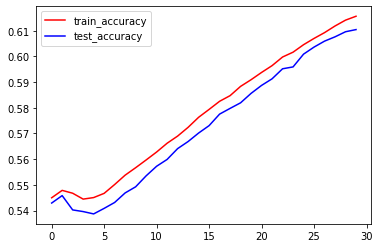

In [0]:
# Visualise train / Valid Accuracy
plt.plot(history_bce.history["macro_f1"], c="r", label="train_accuracy")
plt.plot(history_bce.history["val_macro_f1"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

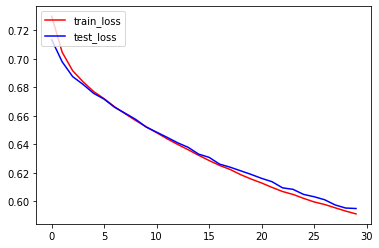

In [0]:
# Visualise train / Valid Loss
plt.plot(history_bce.history["loss"], c="r", label="train_loss")
plt.plot(history_bce.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

* Regardez un exemple de prédictions par rapport à la réalité 

Preds : [0.94808865 0.99979335 0.9999522  0.99980646 0.03850565 0.99954164
 0.99979585 0.04142694 0.999838  ]
Truth : [1 0 0 1 0 0 0 0 1]


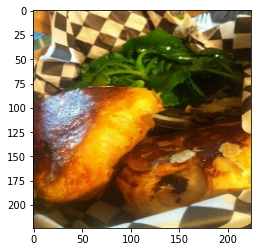

In [0]:
for x, y in train_ds.take(1):
  y_pred = model.predict(x)
  print("Preds : {}\nTruth : {}".format(y_pred[0], y[0].numpy()))
  plt.imshow(x[0])

# Pour aller plus loin - MobileNetV2 Trainable - loss = BinaryCE

* [Multi-Label Image Classification in TensorFlow 2.0.ipynb](https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb)

* [Kaggle API](https://github.com/Kaggle/kaggle-api)

In [35]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                                              include_top=False,
                                              weights = "imagenet"
                                              )

base_model.trainable = True

fine_tune_at = len(base_model.layers)-100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


model_mobile = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(524, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(124, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(9, activation="sigmoid")
])

# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.90,
    staircase=True)

model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics = [tf.keras.metrics.BinaryAccuracy(), macro_f1])

9412608/9406464 [==============================] - 0s 0us/step


In [36]:
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 524)               537100    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               134400    
_________________________________________________________________
dense_3 (Dense)              (None, 124)               31868     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8

In [0]:
start = time()

history_mobile = model_mobile.fit(train_ds,
                                  epochs=10,
                                  validation_data=create_dataset(X_val, y_val_bin))

print('\nTraining took {0:4.2f} min'.format(int(time()-start)/60))

Epoch 1/10
74/74 [==============================] - 28s 382ms/step - loss: 0.5798 - binary_accuracy: 0.6814 - macro_f1: 0.5667 - val_loss: 0.5539 - val_binary_accuracy: 0.7164 - val_macro_f1: 0.6507
Epoch 2/10
74/74 [==============================] - 26s 345ms/step - loss: 0.4702 - binary_accuracy: 0.7588 - macro_f1: 0.6880 - val_loss: 0.5644 - val_binary_accuracy: 0.7302 - val_macro_f1: 0.6541
Epoch 3/10
74/74 [==============================] - 26s 347ms/step - loss: 0.4018 - binary_accuracy: 0.8035 - macro_f1: 0.7687 - val_loss: 0.5695 - val_binary_accuracy: 0.7373 - val_macro_f1: 0.6581
Epoch 4/10
74/74 [==============================] - 26s 346ms/step - loss: 0.3452 - binary_accuracy: 0.8375 - macro_f1: 0.8123 - val_loss: 0.6008 - val_binary_accuracy: 0.7382 - val_macro_f1: 0.6829
Epoch 5/10
74/74 [==============================] - 26s 345ms/step - loss: 0.3045 - binary_accuracy: 0.8606 - macro_f1: 0.8386 - val_loss: 0.7218 - val_binary_accuracy: 0.7198 - val_macro_f1: 0.6809
Epoch

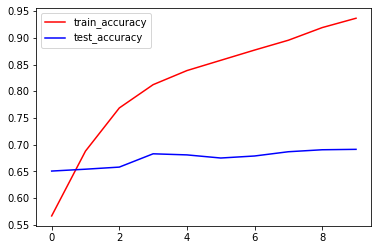

In [0]:
# Visualise train / Valid Accuracy
plt.plot(history_mobile.history["macro_f1"], c="r", label="train_accuracy")
plt.plot(history_mobile.history["val_macro_f1"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

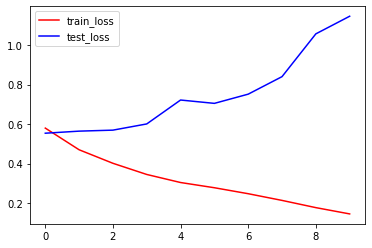

In [0]:
# Visualise train / Valid Loss
plt.plot(history_mobile.history["loss"], c="r", label="train_loss")
plt.plot(history_mobile.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# MobileNetV2 Trainable -> loss = macro_f1


In [0]:
base_model_V2 = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                                              include_top=False,
                                              weights = "imagenet"
                                              )

base_model_V2.trainable = True

fine_tune_at = len(base_model_V2.layers)-140
for layer in base_model_V2.layers[:fine_tune_at]:
  layer.trainable = False


model_mobile_V2 = tf.keras.Sequential([
    base_model_V2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(524, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(124, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(9, activation="sigmoid")
])

# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.90,
    staircase=True)

model_mobile_V2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
            loss = macro_soft_f1,
            metrics = [tf.keras.metrics.BinaryAccuracy(), macro_f1])

In [38]:
model_mobile_V2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_8 (Dense)              (None, 524)               537100    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               134400    
_________________________________________________________________
dense_10 (Dense)             (None, 124)               31868     
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

In [39]:
start = time()

history_mobile_V2 = model_mobile_V2.fit(train_ds,
                                  epochs=40,
                                  validation_data=create_dataset(X_val, y_val_bin))

print('\nTraining took {0:4.2f} min'.format(int(time()-start)/60))

Epoch 1/40
74/74 [==============================] - 51s 692ms/step - loss: 0.3441 - binary_accuracy: 0.5266 - macro_f1: 0.6634 - val_loss: 0.3257 - val_binary_accuracy: 0.5281 - val_macro_f1: 0.6740
Epoch 2/40
74/74 [==============================] - 43s 580ms/step - loss: 0.3169 - binary_accuracy: 0.5451 - macro_f1: 0.6829 - val_loss: 0.3077 - val_binary_accuracy: 0.5800 - val_macro_f1: 0.6930
Epoch 3/40
74/74 [==============================] - 43s 579ms/step - loss: 0.2949 - binary_accuracy: 0.5958 - macro_f1: 0.7056 - val_loss: 0.3740 - val_binary_accuracy: 0.5617 - val_macro_f1: 0.6262
Epoch 4/40
74/74 [==============================] - 43s 580ms/step - loss: 0.2863 - binary_accuracy: 0.6084 - macro_f1: 0.7140 - val_loss: 0.3997 - val_binary_accuracy: 0.5508 - val_macro_f1: 0.6001
Epoch 5/40
74/74 [==============================] - 43s 580ms/step - loss: 0.2815 - binary_accuracy: 0.6159 - macro_f1: 0.7188 - val_loss: 0.4903 - val_binary_accuracy: 0.5055 - val_macro_f1: 0.5093
Epoch

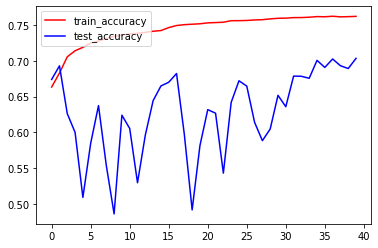

In [40]:
# Visualise train / Valid Accuracy
plt.plot(history_mobile_V2.history["macro_f1"], c="r", label="train_accuracy")
plt.plot(history_mobile_V2.history["val_macro_f1"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

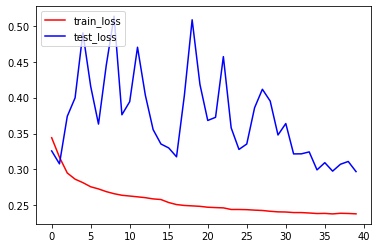

In [41]:
# Visualise train / Valid Loss
plt.plot(history_mobile_V2.history["loss"], c="r", label="train_loss")
plt.plot(history_mobile_V2.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# Data Augmentation

In [0]:
@tf.function
def data_aug(img, lbl):
  img = tf.image.random_brightness(img, 0.5)
  img = tf.image.random_contrast(img, 0.5, 4)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_crop(img, [224, 224, 3])
  img = tf.image.random_hue(img, 0.5)
  return img, lbl

In [0]:
train_ds_aug = train_ds.unbatch().map(data_aug)

In [0]:
train_ds_aug = train_ds_aug.batch(BATCH_SIZE)

In [45]:
for f, l in train_ds_aug.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 9)


In [54]:
model_mobile_aug = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu'),
    layers.Dense(524, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(124, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model_mobile_aug.summary()

model_mobile_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
            loss = macro_soft_f1,
            metrics = [tf.keras.metrics.BinaryAccuracy(), macro_f1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dense_40 (Dense)             (None, 524)               537100    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               134400    
_________________________________________________________________
dense_42 (Dense)             (None, 124)               31868     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8000      
_________________________________________________________________
dense_44 (Dense)             (None, 32)               

In [56]:
start = time()

history_mobile_aug = model_mobile_aug.fit(train_ds_aug,
                                  epochs=10,
                                  validation_data=create_dataset(X_val, y_val_bin))

print('\nTraining took {0:4.2f} min'.format(int(time()-start)/60))

Epoch 1/10
74/74 [==============================] - 33s 441ms/step - loss: 0.4615 - binary_accuracy: 0.5375 - macro_f1: 0.5230 - val_loss: 0.4421 - val_binary_accuracy: 0.5119 - val_macro_f1: 0.4947
Epoch 2/10
74/74 [==============================] - 31s 424ms/step - loss: 0.4158 - binary_accuracy: 0.5297 - macro_f1: 0.5264 - val_loss: 0.4095 - val_binary_accuracy: 0.5724 - val_macro_f1: 0.6181
Epoch 3/10
74/74 [==============================] - 32s 428ms/step - loss: 0.3829 - binary_accuracy: 0.5880 - macro_f1: 0.6554 - val_loss: 0.3788 - val_binary_accuracy: 0.5768 - val_macro_f1: 0.6787
Epoch 4/10
74/74 [==============================] - 33s 444ms/step - loss: 0.3558 - binary_accuracy: 0.5496 - macro_f1: 0.6810 - val_loss: 0.3566 - val_binary_accuracy: 0.5354 - val_macro_f1: 0.6762
Epoch 5/10
74/74 [==============================] - 32s 427ms/step - loss: 0.3385 - binary_accuracy: 0.5335 - macro_f1: 0.6780 - val_loss: 0.3420 - val_binary_accuracy: 0.5304 - val_macro_f1: 0.6753
Epoch

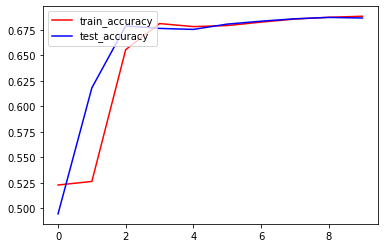

In [57]:
# Visualise train / Valid Accuracy
plt.plot(history_mobile_aug.history["macro_f1"], c="r", label="train_accuracy")
plt.plot(history_mobile_aug.history["val_macro_f1"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

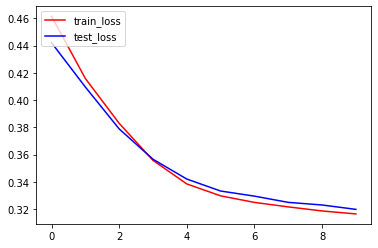

In [58]:
# Visualise train / Valid Loss
plt.plot(history_mobile_aug.history["loss"], c="r", label="train_loss")
plt.plot(history_mobile_aug.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()